In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras import layers,optimizers,losses
from tensorflow.keras.datasets import fashion_mnist

from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier

#  Read data

In [2]:
(x_train,y_train),(x_test,y_test) = fashion_mnist.load_data()
x_train = np.expand_dims(x_train,axis=3)/255.
x_test = np.expand_dims(x_test,axis=3)/255.
flatten_x_train = np.reshape(x_train,(x_train.shape[0],-1))
flatten_x_test = np.reshape(x_test,(x_test.shape[0],-1))

# Variational AutoEncoder

### Dense

In [3]:
class DenseVAE(Model):
    def __init__(self, hidden_dim, latent_dim, original_dim):
        super(DenseVAE, self).__init__()
        self.fc1 = layers.Dense(hidden_dim)
        self.fc11 = layers.Dense(hidden_dim//2)
        self.fc2 = layers.Dense(latent_dim)
        self.fc3 = layers.Dense(latent_dim)
        self.fc4 = layers.Dense(hidden_dim//2)
        self.fc44 = layers.Dense(hidden_dim)
        self.fc5 = layers.Dense(original_dim,activation='relu')

    def call(self, inputs):
        mu, log_var = self.encode(inputs)
        z = self.reparameterize(mu, log_var)
        x_reconstructed_logits = self.decode_logits(z)
        return x_reconstructed_logits, mu, log_var

    def encode(self, x):
        h = tf.nn.relu(self.fc1(x))
        h = tf.nn.relu(self.fc11(h))
        return self.fc2(h), self.fc3(h)
    
    def reparameterize(self, mu, log_var):
        std = tf.exp(log_var)
        eps = tf.random.normal(std.shape,mean=0.,stddev=1.)
        return mu + eps * std

    def decode_logits(self, z):
        h = tf.nn.relu(self.fc4(z))
        h = tf.nn.relu(self.fc44(h))
        return self.fc5(h)

    def decode(self, z):
        return tf.nn.sigmoid(self.decode_logits(z))

In [4]:
max_epochs = 100
batch_size= 64
learning_rate = 0.001
original_dim = x_train.shape[1]* x_train.shape[2]

#### latent_dim = 2

In [5]:
latent_dim = 2
hidden_dim = 128
dense_vae = DenseVAE(hidden_dim, latent_dim,original_dim)
optimizer = optimizers.legacy.SGD(learning_rate)
kl_div = losses.KLDivergence()

In [6]:
ds_loader = tf.data.Dataset.from_tensor_slices(flatten_x_train)
dense_vae_loss = []
for epoch in range(max_epochs):
  loss_ = []
  for data_batch in ds_loader.batch(batch_size):
    with tf.GradientTape() as tape:
      x_reconstructed_logits, mu, log_var = dense_vae(data_batch)
      loss = kl_div(x_reconstructed_logits,data_batch)
    grads = tape.gradient(loss, dense_vae.trainable_variables)
    optimizer.apply_gradients(zip(grads, dense_vae.trainable_variables))
    loss_.append(loss)
  dense_vae_loss.append(np.mean(loss_))
  print('epoch : ', epoch ,' loss: ' , loss)


epoch :  0  loss:  tf.Tensor(-38.93051377698618, shape=(), dtype=float64)
epoch :  1  loss:  tf.Tensor(-43.14112470205032, shape=(), dtype=float64)
epoch :  2  loss:  tf.Tensor(-45.2723864587483, shape=(), dtype=float64)
epoch :  3  loss:  tf.Tensor(-46.5403548149895, shape=(), dtype=float64)
epoch :  4  loss:  tf.Tensor(-47.03828264845133, shape=(), dtype=float64)
epoch :  5  loss:  tf.Tensor(-47.15986204059803, shape=(), dtype=float64)
epoch :  6  loss:  tf.Tensor(-47.23907599220825, shape=(), dtype=float64)
epoch :  7  loss:  tf.Tensor(-47.63320653245335, shape=(), dtype=float64)
epoch :  8  loss:  tf.Tensor(-48.013279528269855, shape=(), dtype=float64)
epoch :  9  loss:  tf.Tensor(-48.53142986743872, shape=(), dtype=float64)
epoch :  10  loss:  tf.Tensor(-48.78605651100355, shape=(), dtype=float64)
epoch :  11  loss:  tf.Tensor(-49.23500112904435, shape=(), dtype=float64)
epoch :  12  loss:  tf.Tensor(-49.63114326763191, shape=(), dtype=float64)
epoch :  13  loss:  tf.Tensor(-50.03

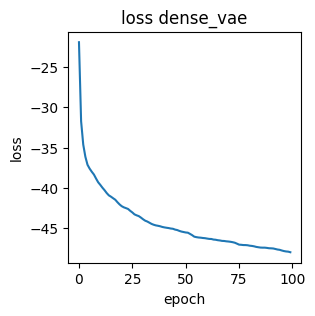

In [7]:
plt.figure(figsize=(3,3))
plt.plot(range(len(dense_vae_loss)),dense_vae_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss dense_vae')
plt.savefig("loss dense_vae 2.png")
plt.show()


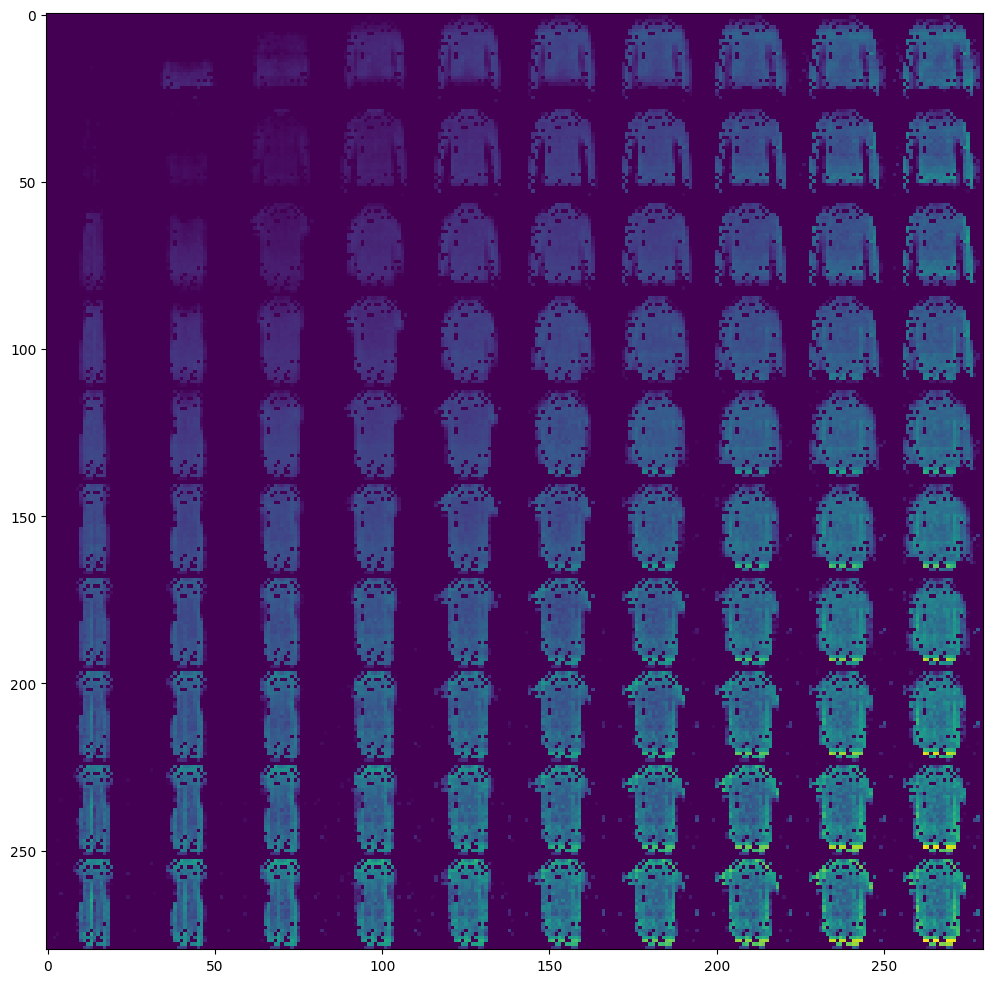

In [11]:
n = 10  # figure with 15x15 digits

target_size = 28
figure = np.zeros((target_size * n, target_size * n))

grid_x = np.linspace(0, 10, n)
grid_y = np.linspace(0, 10, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * 1.
        x_decoded = dense_vae.decode(z_sample)

        fashion = np.reshape(x_decoded[0],(target_size, target_size))
        figure[i * target_size: (i + 1) * target_size,
                j * target_size: (j + 1) * target_size] = fashion
plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.tight_layout()
plt.savefig('dense_vae_generated_image2.png' )
plt.show() 

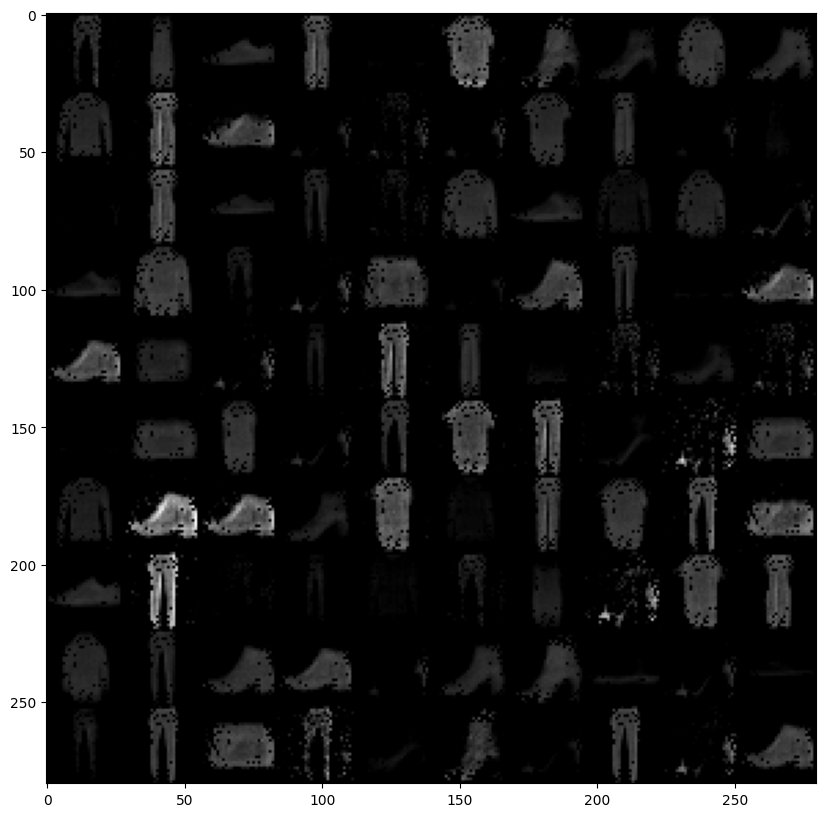

In [12]:
n = 10  # figure with 15x15

target_size = 28
figure = np.zeros((target_size * n, target_size * n))
z = tf.random.normal((n*n, latent_dim),mean=0,stddev=5.)
fashion = (dense_vae.decode(z).numpy().reshape((-1,target_size,target_size))*255).astype(np.uint8)
for i in range(n):
    for j in range(n):
        figure[i * target_size: (i + 1) * target_size,
                j * target_size: (j + 1) * target_size] = np.asarray(fashion[i*n+j])
        
plt.figure(figsize=(10, 10))
plt.imshow(figure,cmap='gray')
plt.show() 

In [13]:
knn = KNeighborsClassifier()
param_distributions = {"n_neighbors":list(range(1,30))}
clf = RandomizedSearchCV(knn,param_distributions,cv=10)
_, mu, log_var = dense_vae(flatten_x_train)
z = dense_vae.reparameterize(mu,log_var)
dense_vae_x_train = z.numpy().reshape((len(x_train),-1))

_, mu, log_var = dense_vae(flatten_x_test)
z = dense_vae.reparameterize(mu,log_var)
dense_vae_x_test = z.numpy().reshape((len(x_test),-1))

clf.fit(dense_vae_x_train,y_train)

knn_cnn_autencoder = clf.best_estimator_
print('knn score for dense_vae reduction on train dataset : ',knn_cnn_autencoder.score(dense_vae_x_train,y_train))
print('knn score for dense_vae reduction on test dataset : ',knn_cnn_autencoder.score(dense_vae_x_test,y_test))

knn score for dense_vae reduction on train dataset :  0.7545333333333333
knn score for dense_vae reduction on test dataset :  0.7224


#### latent_dim = 3


In [14]:
latent_dim = 3
hidden_dim = 128
dense_vae = DenseVAE(hidden_dim, latent_dim,original_dim)
optimizer = optimizers.legacy.SGD(learning_rate)
kl_div = losses.KLDivergence()
ds_loader = tf.data.Dataset.from_tensor_slices(flatten_x_train)

In [15]:
dense_vae_loss = []
for epoch in range(max_epochs):
  loss_ = []
  for data_batch in ds_loader.batch(batch_size):
    with tf.GradientTape() as tape:
      x_reconstructed_logits, mu, log_var = dense_vae(data_batch)
      loss = kl_div(x_reconstructed_logits,data_batch)
    grads = tape.gradient(loss, dense_vae.trainable_variables)
    optimizer.apply_gradients(zip(grads, dense_vae.trainable_variables))    
    loss_.append(loss)

  dense_vae_loss.append(np.mean(loss_))
  print('epoch : ', epoch ,' loss: ' , loss)


epoch :  0  loss:  tf.Tensor(-42.26577928749089, shape=(), dtype=float64)
epoch :  1  loss:  tf.Tensor(-48.544925720504295, shape=(), dtype=float64)
epoch :  2  loss:  tf.Tensor(-50.8008328353606, shape=(), dtype=float64)
epoch :  3  loss:  tf.Tensor(-52.322252427604624, shape=(), dtype=float64)
epoch :  4  loss:  tf.Tensor(-53.63478465335798, shape=(), dtype=float64)
epoch :  5  loss:  tf.Tensor(-54.41991729384232, shape=(), dtype=float64)
epoch :  6  loss:  tf.Tensor(-55.21457625552785, shape=(), dtype=float64)
epoch :  7  loss:  tf.Tensor(-55.769853222136774, shape=(), dtype=float64)
epoch :  8  loss:  tf.Tensor(-56.322688741480206, shape=(), dtype=float64)
epoch :  9  loss:  tf.Tensor(-57.02785550911208, shape=(), dtype=float64)
epoch :  10  loss:  tf.Tensor(-57.52845632265003, shape=(), dtype=float64)
epoch :  11  loss:  tf.Tensor(-57.84325118281082, shape=(), dtype=float64)
epoch :  12  loss:  tf.Tensor(-58.25345920802424, shape=(), dtype=float64)
epoch :  13  loss:  tf.Tensor(-5

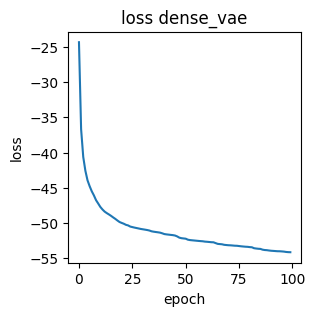

In [16]:
plt.figure(figsize=(3,3))
plt.plot(range(len(dense_vae_loss)),dense_vae_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss dense_vae')
plt.savefig("loss dense_vae 3.png")
plt.show()

In [18]:
knn = KNeighborsClassifier()
param_distributions = {"n_neighbors":list(range(1,30))}
clf = RandomizedSearchCV(knn,param_distributions,cv=10)
_, mu, log_var = dense_vae(flatten_x_train)
z = dense_vae.reparameterize(mu,log_var)
dense_vae_x_train = z.numpy().reshape((len(x_train),-1))

_, mu, log_var = dense_vae(flatten_x_test)
z = dense_vae.reparameterize(mu,log_var)
dense_vae_x_test = z.numpy().reshape((len(x_test),-1))

clf.fit(dense_vae_x_train,y_train)

knn_cnn_autencoder = clf.best_estimator_
print('knn score for dense_vae reduction on train dataset : ',knn_cnn_autencoder.score(dense_vae_x_train,y_train))
print('knn score for dense_vae reduction on test dataset : ',knn_cnn_autencoder.score(dense_vae_x_test,y_test))

knn score for dense_vae reduction on train dataset :  0.7837833333333334
knn score for dense_vae reduction on test dataset :  0.7578


#### CNN

In [19]:
class CNNVAE(Model):
    def __init__(self, latent_dim):
        super(CNNVAE, self).__init__()
        self.conv1 = layers.Conv2D(16, (3,3), activation = 'relu', padding = "SAME")
        self.conv1_1 = layers.Conv2D(64, (3,3), activation = 'relu', padding = "SAME")
        self.pool1 = layers.MaxPooling2D(pool_size = (2,2), strides = 2)
        self.conv2 = layers.Conv2D(128, (3,3), activation = 'relu', padding = "SAME")
        self.pool2 = layers.MaxPooling2D(pool_size = (2,2), strides = 2)

        self.flat = layers.Flatten()
        self.input_to_z = layers.Dense(32, activation = 'relu')
        self.mu = layers.Dense(latent_dim,  name='mu')
        self.sigma = layers.Dense(latent_dim,  name='log_var')
        
        self.dense_layer_d = layers.Dense(7*7*128,)
        self.output_from_z_d = layers.Reshape((7,7,128))
        self.trans1_d = layers.Conv2DTranspose(64, 3,  strides=(2, 2),padding='same', activation='relu')
        self.trans1_d1 = layers.Conv2DTranspose(16, 3,  strides=(2, 2),padding='same', activation='relu')
        self.trans2_d = layers.Conv2DTranspose(1, 3, padding='same', activation='relu')


    def call(self, inputs):
        mu, log_var = self.encode(inputs)
        z = self.reparameterize(mu, log_var)
        x_reconstructed_logits = self.decode_logits(z)
        return x_reconstructed_logits, mu, log_var

    def encode(self, x):
        x = self.conv1(x)
        x = self.conv1_1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flat(x)
        x = self.input_to_z(x)
        return self.mu(x), self.sigma(x)

    def reparameterize(self, mu, log_var):
        std = tf.exp(log_var)
        eps = tf.random.normal(std.shape,mean=0.,stddev=1.)
        return mu + eps * std

    def decode_logits(self, z):
        z = self.dense_layer_d(z)
        z = self.output_from_z_d(z)
        z = self.trans1_d(z)
        z = self.trans1_d1(z)
        z = self.trans2_d(z)
        return z

    def decode(self, z):
        return tf.nn.sigmoid(self.decode_logits(z))

#### latent_dim = 2

In [20]:

latent_dim = 2
cnn_vae = CNNVAE(latent_dim)
cnn_vae.compile()
optimizer = optimizers.legacy.Adam(learning_rate)
kl_div = losses.KLDivergence()
ds_loader = tf.data.Dataset.from_tensor_slices(x_train)
cnn_vae_loss = []
for epoch in range(max_epochs):
  loss_ = []
  for data_batch in ds_loader.batch(batch_size):
    with tf.GradientTape() as tape:
      x_reconstructed_logits, mu, log_var = cnn_vae(data_batch)
      loss = kl_div(x_reconstructed_logits,data_batch)
    grads = tape.gradient(loss, cnn_vae.trainable_variables)
    optimizer.apply_gradients(zip(grads, cnn_vae.trainable_variables))
    loss_.append(loss)

  cnn_vae_loss.append(np.mean(loss_))
  print('epoch : ', epoch ,' loss: ' , np.mean(loss_))


epoch :  0  loss:  -0.05654170279146457
epoch :  1  loss:  -0.06442852991092773
epoch :  2  loss:  -0.06607455197580686
epoch :  3  loss:  -0.06734229620680965
epoch :  4  loss:  -0.06815372878379494
epoch :  5  loss:  -0.06875556216365607
epoch :  6  loss:  -0.0693691253596698
epoch :  7  loss:  -0.06987553184176494
epoch :  8  loss:  -0.0703062540770181
epoch :  9  loss:  -0.07072817709752038
epoch :  10  loss:  -0.07107326131095965
epoch :  11  loss:  -0.07143216162901717
epoch :  12  loss:  -0.07176284815897768
epoch :  13  loss:  -0.07201644069143004
epoch :  14  loss:  -0.07213873066571473
epoch :  15  loss:  -0.07249017273610991
epoch :  16  loss:  -0.07270469354190226
epoch :  17  loss:  -0.07256126355290825
epoch :  18  loss:  -0.07285148073301242
epoch :  19  loss:  -0.0731112083909483
epoch :  20  loss:  -0.07320372334903731
epoch :  21  loss:  -0.07346584259461739
epoch :  22  loss:  -0.07335609151669845
epoch :  23  loss:  -0.07363401430960749
epoch :  24  loss:  -0.073735

In [ ]:
n = 10  # figure with 15x15 digits

target_size = 28
figure = np.zeros((target_size * n, target_size * n))

grid_x = np.linspace(0, 10, n)
grid_y = np.linspace(0, 10, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * 1.
        x_decoded = cnn_vae.decode(z_sample)

        fashion = np.reshape(x_decoded[0],(target_size, target_size))
        figure[i * target_size: (i + 1) * target_size,
                j * target_size: (j + 1) * target_size] = fashion
plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.tight_layout()
plt.savefig('cnn_vae_generated_image.png' )
plt.show() 

In [ ]:
n = 10  # figure with 15x15

target_size = 28
figure = np.zeros((target_size * n, target_size * n))
mu = tf.random.normal((n*n, latent_dim))
log_var = tf.random.normal((n*n, latent_dim))
z = cnn_vae.reparameterize(mu,log_var)
target_size = cnn_vae.decode(z).numpy().reshape((-1,target_size,target_size))
for i in range(n):
    for j in range(n):
        figure[i * target_size: (i + 1) * target_size,
                j * target_size: (j + 1) * target_size] = np.asarray(fashion[i*n+j])
        
plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show() 

In [ ]:
plt.figure(figsize=(3,3))
plt.plot(range(len(cnn_vae_loss)),cnn_vae_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss cnn_vae')
plt.savefig("loss cnn_vae 2.png")
plt.show()

In [ ]:
knn = KNeighborsClassifier()
param_distributions = {"n_neighbors":list(range(1,30))}
clf = RandomizedSearchCV(knn,param_distributions,cv=10)
_, mu, log_var = cnn_vae(x_train)
z = cnn_vae.reparameterize(mu,log_var)
cnn_vae_x_train = z.numpy().reshape((len(x_train),-1))

_, mu, log_var = cnn_vae(x_test)
z = cnn_vae.reparameterize(mu,log_var)
cnn_vae_x_test = z.numpy().reshape((len(x_test),-1))

clf.fit(cnn_vae_x_train,y_train)

knn_cnn_autencoder = clf.best_estimator_
print('knn score for cnn_vae reduction on train dataset : ',knn_cnn_autencoder.score(cnn_vae_x_train,y_train))
print('knn score for cnn_vae reduction on test dataset : ',knn_cnn_autencoder.score(cnn_vae_x_test,y_test))

#### latent_dim = 3

In [ ]:
latent_dim = 3
cnn_vae = CNNVAE(latent_dim)
cnn_vae.compile()
optimizer = optimizers.legacy.SGD(learning_rate)
kl_div = losses.KLDivergence()
ds_loader = tf.data.Dataset.from_tensor_slices(x_train)
cnn_vae_loss = []
for epoch in range(max_epochs):
  loss_ = []
  for data_batch in ds_loader.batch(batch_size):
    with tf.GradientTape() as tape:
      x_reconstructed_logits, mu, log_var = cnn_vae(data_batch)
      loss = kl_div(x_reconstructed_logits,data_batch)
    grads = tape.gradient(loss, cnn_vae.trainable_variables)
    optimizer.apply_gradients(zip(grads, cnn_vae.trainable_variables))
    loss_.append(loss)

  cnn_vae_loss.append(np.mean(loss_))
  print('epoch : ', epoch ,' loss: ' , loss)
  



In [ ]:
n = 10  # figure with 15x15

target_size = 28
figure = np.zeros((target_size * n, target_size * n))
mu = tf.random.normal((n*n, latent_dim))
log_var = tf.random.normal((n*n, latent_dim))
z = cnn_vae.reparameterize(mu,log_var)
fashion = cnn_vae.decode(z).numpy().reshape((-1,target_size,target_size))
for i in range(n):
    for j in range(n):
        figure[i * target_size: (i + 1) * target_size,
                j * target_size: (j + 1) * target_size] = np.asarray(fashion[i*n+j])
        
plt.figure(figsize=(10, 10))
plt.imshow(figure,cmap='gray')
plt.show() 

In [ ]:
plt.figure(figsize=(3,3))
plt.plot(range(len(cnn_vae_loss)),cnn_vae_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss cnn_vae')
plt.savefig("loss cnn_vae 3.png")
plt.show()

In [ ]:
knn = KNeighborsClassifier()
param_distributions = {"n_neighbors":list(range(1,30))}
clf = RandomizedSearchCV(knn,param_distributions,cv=10)
_, mu, log_var = cnn_vae(x_train)
z = cnn_vae.reparameterize(mu,log_var)
cnn_vae_x_train = z.numpy().reshape((len(x_train),-1))

_, mu, log_var = cnn_vae(x_test)
z = cnn_vae.reparameterize(mu,log_var)
cnn_vae_x_test = z.numpy().reshape((len(x_test),-1))

clf.fit(cnn_vae_x_train,y_train)

knn_cnn_autencoder = clf.best_estimator_
print('knn score for cnn_vae reduction on train dataset : ',knn_cnn_autencoder.score(cnn_vae_x_train,y_train))
print('knn score for cnn_vae reduction on test dataset : ',knn_cnn_autencoder.score(cnn_vae_x_test,y_test))